In [1]:
import ROOT
import os
from xml_handle_new import *
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import matplotlib.colors as colors
import uproot

Welcome to JupyROOT 6.26/10


### Useful Functions

In [24]:

def Ecal(x,a,b,c):
    return a*x**2 + x*b + c

def countelements(arr, start, stop):
    counts = 0
    for j in arr:
        if start <= j <= stop:
            counts += 1
    return counts

def newcounts(xavgpd, binrange, binnum, sfactor):

    windows = np.linspace(binrange[0],binrange[1], binnum)
    ogcounts = np.zeros(len(windows))
    # newcounts = np.zeros(len(windows))

    windowout = np.linspace(binrange[0],binrange[1]+15, binnum+1)
    newcounts = np.zeros((len(ogcounts)))
    for i in range(len(windows)-1):
        # finding the amount of counts in each bin originally
        ogcounts[i] = countelements(np.array(xavgpd), windows[i], windows[i+1])

        # multiplying by the scaling factor
        # newcounts[i,0] = windowout[i]
        newcounts[i] = ogcounts[i]*sfactor
    

    return newcounts, ogcounts, windowout

    
def TcutCEandxavg(start, finish, path, tshift,twidth,gamma):

    run_list = []
    for filename in os.listdir(path):
        if filename.endswith(".root"):
            run_number = int(filename.split("_")[1].split(".")[0])
            run_list.append(run_number)

    run_list.sort()

    
    combine_detCE = []; combine_detxavg = []


    for i in run_list:
        if i >= start:
            if i <= finish:

                # print(i)
                df = ROOT.RDataFrame("SPSTree",f"{path}run_{i}.root")
                    
                final_CE = []; finalCEarr = []
                final_xavg = []; finalxavgarr = []                 
            
                for j in range(5):

                    df_i = df.Filter(f"cebraE{j} != -1")
                    

                    dettimecut1 = df_i.Define(f"cebra_RelTime_toScint_{j}", f"cebraTime{j} - scintLeftTime + {tshift[j]}")
                    timecut = f"cebra_RelTime_toScint_{j} > {-twidth} && cebra_RelTime_toScint_{j} < {twidth}"
                    dettimecut = dettimecut1.Filter(f"{timecut}")

                    final_CE.append(pd.DataFrame(dettimecut.AsNumpy(columns = [f'cebraE{j}_GM'])))
                    finalCEarr.append(np.array(final_CE[j][f'cebraE{j}_GM']))

                    final_xavg.append(pd.DataFrame(dettimecut.AsNumpy(columns = ['xavg'])))
                   
                
                combine_detCE.append(np.concatenate(finalCEarr, axis = 0))
                combine_detxavg.append(pd.concat(final_xavg, axis = 0))

    totaldetCE = np.concatenate(combine_detCE, axis = 0)
    totaldetxavg = pd.concat(combine_detxavg, axis = 0)
    
    if gamma == True:
        return totaldetCE
    if gamma == False:
        return totaldetxavg

In [25]:
def xavg(start, finish, path):

    run_list = []
    for filename in os.listdir(path):
        if filename.endswith(".root"):
            run_number = int(filename.split("_")[1].split(".")[0])
            run_list.append(run_number)

    run_list.sort()

    # combine_detxavg = []
    final_xavg = []
    for i in run_list:
        if i >= start:
            if i <= finish:
    
                
                
                root_df = ROOT.RDataFrame("SPSTree", f"{path}/run_{i}.root")
                PID_filter_cond = "scintLeftTime != -1e6 && anodeBackTime != -1e6 && xavg != -1e6"
                root_df_filtered = root_df.Filter(f"{PID_filter_cond}")
                # df_f = root_df_filtered.AsNumpy(columns = ["xavg"])
                final_xavg.append(pd.DataFrame(root_df_filtered.AsNumpy(columns = ['xavg'])))

    combine_detxavg = pd.concat(final_xavg, axis = 0)
    return combine_detxavg

### Using combineCEandxavg to get xavg data and energy calibrating them

In [18]:
path = '/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Workingdir/analyzed/GMandcut'

tshift = [[710,708,707,707,677], [722,721,720,719,690],[736,733,734,733,703],\
          [746,745,745,744,714],[757,756,754,753,724],[774,772,772,771,742]]
twidth = 6
SLABpar = [[335,750,470,1290],[189,994,559,1290],[118,395,685,1402],\
           [68, 311,800,1460],[61, 230,920,1520],[12,152,1145,1640]]
print(SLABpar[1][1])

994


Text(0.5, 1.0, '')

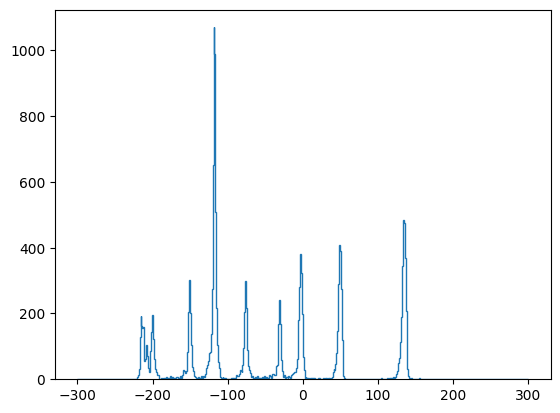

In [23]:
xavg4_30 = xavg(4,30,path)

plt.figure()
plt.hist(xavg4_30 ,bins = 500, range = [-300,300], histtype= 'step', label = 'runs 4-30')
plt.title('')

In [26]:
xavg4_30 =  xavg(4,30,path)
xavg31_38 = xavg(31,38,path)
xavg39_53 = xavg(39,53,path)
xavg68_84 = xavg(68,84,path)
xavg85_112 =xavg(85,112,path)
xavg113_134=xavg(113,134,path)


In [27]:
fitpar = [[-0.0030797,-14.3656, 1984.7056],[-0.00204,-11.03256,5251.766]\
          ,[-0.0008726,-8.6791,7840.8340],[0.00329886,-8.18386,9405.789],[0.0031105,-8.31563,10585.9494]\
          ,[0.002247, -8.28524,12746.2791]]

xavgcal4_30   = Ecal(xavg4_30['xavg'], *fitpar[0])
xavgcal31_38  = Ecal(xavg31_38['xavg']  , *fitpar[1])
xavgcal39_53  = Ecal(xavg39_53['xavg']  , *fitpar[2])
xavgcal68_84  = Ecal(xavg68_84['xavg']  , *fitpar[3])
xavgcal85_112 = Ecal(xavg85_112['xavg'] , *fitpar[4])
xavgcal113_134= Ecal(xavg113_134['xavg'], *fitpar[5])

totaldeutE = np.concatenate((xavgcal4_30, xavgcal31_38, xavgcal39_53, xavgcal68_84, xavgcal85_112, xavgcal113_134))


(0.0, 2000.0)

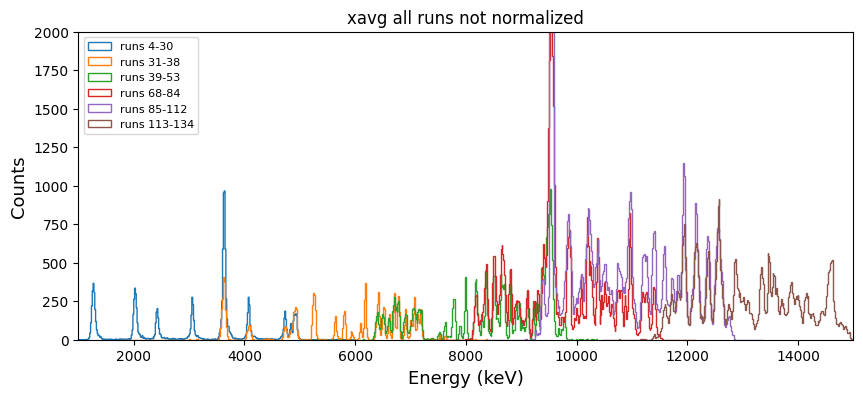

In [29]:
plt.figure(figsize = (10,4))
# plt.hist(totaldeutE/1000, bins = 1202, range = [-2.602,15.434], histtype= 'step')
plt.hist(xavgcal4_30   , bins = 575, range = [-2602,6017], histtype= 'step', label = 'runs 4-30')
plt.hist(xavgcal31_38  , bins = 441, range = [1758,8378], histtype= 'step' , label = 'runs 31-38')
plt.hist(xavgcal39_53  , bins = 347, range = [5158,10366], histtype= 'step', label = 'runs 39-53')
plt.hist(xavgcal68_84  , bins = 327, range = [7247,12158], histtype= 'step', label = 'runs 68-84')
plt.hist(xavgcal85_112 , bins = 333, range =[8371,13360], histtype= 'step', label = 'runs 85-112')
plt.hist(xavgcal113_134, bins = 331, range=[10462,15434], histtype= 'step', label = 'runs 113-134')
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.title('xavg all runs not normalized')
plt.legend(loc = 'best', fontsize = 8)
plt.xlim(1000,15000)
plt.ylim(0,2000)

### Normalizing runs 31-38 to runs 4-30

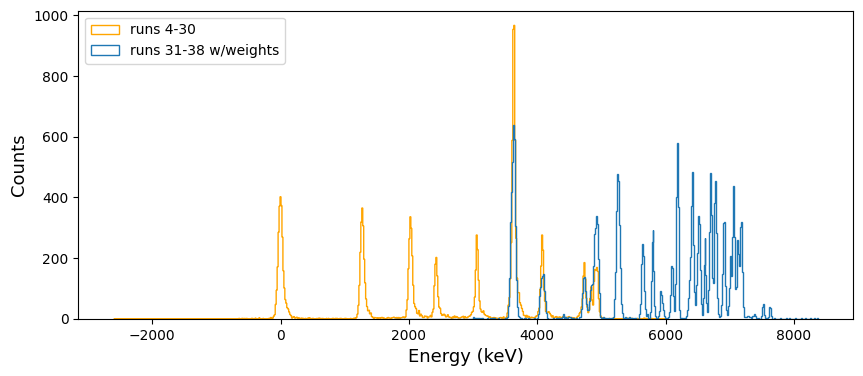

In [34]:
# run31_38scaled, run31_38og, run31_38window = newcounts(xavgcal31_38, [1758,8378], 441, sfactor = 1.32)

plt.figure(figsize = (10,4))
# plt.stairs(run31_38og, run31_38window, color = 'orange' , label = 'Original')
# plt.stairs(run31_38scaled, run31_38window, color = 'black', label = 'runs 31-38 w/stairs')

plt.hist(xavgcal4_30, bins = 575+1, range = [-2602,6017+15], color = 'orange', histtype= 'step', label = 'runs 4-30')
plt.hist(xavgcal31_38, bins = 441, range = [1758,8378], histtype= 'step', label = 'runs 31-38 w/weights', weights = np.full(len(xavgcal31_38),1.58))
# plt.hist(xavgcal39_53/1000, bins = 347, range = [5.158,10.366], histtype= 'step')
# plt.hist(xavgcal68_84/1000, bins = 327, range = [7.247,12.158], histtype= 'step')
# plt.hist(xavgcal85_112/1000, bins = 333, range = [8.371,13.360], histtype= 'step')
# plt.hist(xavgcal113_134/1000, bins = 331, range = [10.462,15.434], histtype= 'step')
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.legend(loc = 'upper left')
# plt.xlim(3500,3800)

### Normalizing runs 39-53

(3500.0, 10000.0)

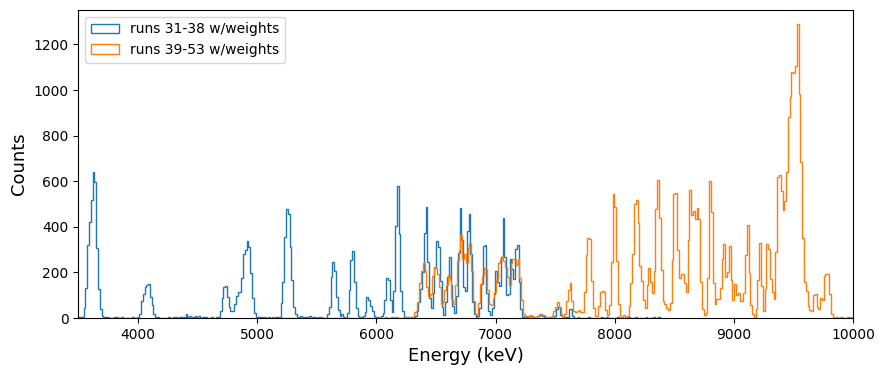

In [36]:
run39_53scaled, run39_53og, run39_53window= newcounts(xavgcal39_53, [5158,10366], 347, sfactor = 0.8*1.7)

plt.figure(figsize = (10,4))
plt.hist(xavgcal31_38, bins = 441, range = [1758,8378], histtype= 'step', label = 'runs 31-38 w/weights', weights = np.full(len(xavgcal31_38),1.58))
plt.hist(xavgcal39_53, bins = 347, range = [5158,10366], histtype= 'step', label = 'runs 39-53 w/weights', weights = np.full(len(xavgcal39_53),1.32))
# plt.hist(xavgcal4_30, bins = 575+1, range = [-2602,6017+15], color = 'orange', histtype= 'step', label = 'runs 4-30')
# plt.hist(xavgcal31_38, bins = 441, range = [1758,8378], histtype= 'step', label = 'runs 31-38')
# plt.hist(xavgcal39_53/1000, bins = 347, range = [5.158,10.366], histtype= 'step')
# plt.hist(xavgcal68_84/1000, bins = 327, range = [7.247,12.158], histtype= 'step')
# plt.hist(xavgcal85_112/1000, bins = 333, range = [8.371,13.360], histtype= 'step')
# plt.hist(xavgcal113_134/1000, bins = 331, range = [10.462,15.434], histtype= 'step')
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.legend(loc = 'upper left')
plt.xlim(3500,10000)

### Normalizing Runs 68-84

(6200.0, 11500.0)

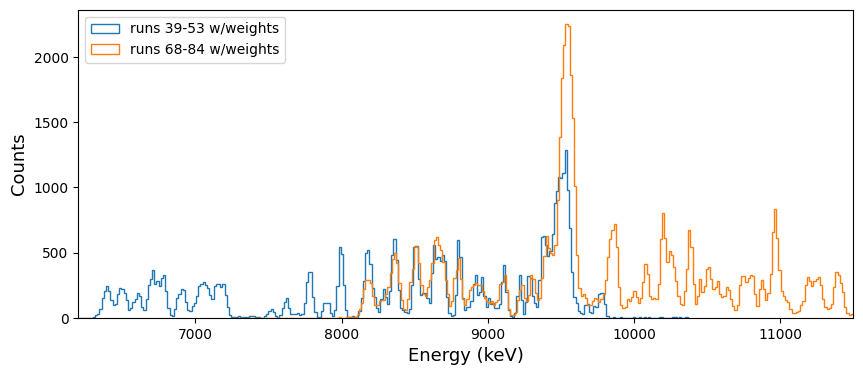

In [37]:
run68_84scaled, run68_84og, run68_84window= newcounts(xavgcal68_84, [7247,12158], 327, sfactor = 0.6*0.8*1.7)

plt.figure(figsize = (10,4))
# plt.stairs(run68_84og, run68_84window, color = 'orange' , label = 'Original')
# plt.stairs(run68_84scaled, run68_84window, color = 'black', label = 'runs 68-84 w/stairs')
# plt.stairs(run39_53scaled, run39_53window, color = 'red', label = 'runs 39-53 scaled (s = 0.8*1.6)')
plt.hist(xavgcal39_53, bins = 347, range = [5158,10366], histtype= 'step', label = 'runs 39-53 w/weights', weights = np.full(len(xavgcal39_53),1.32))
plt.hist(xavgcal68_84, bins = 327, range = [7247,12158], histtype= 'step',label = 'runs 68-84 w/weights', weights = np.full(len(xavgcal68_84),1.01))
# plt.hist(xavgcal4_30, bins = 575+1, range = [-2602,6017+15], color = 'orange', histtype= 'step', label = 'runs 4-30')
# plt.hist(xavgcal31_38, bins = 441, range = [1758,8378], histtype= 'step', label = 'runs 31-38')
# plt.hist(xavgcal39_53/1000, bins = 347, range = [5158,10366], histtype= 'step')
# plt.hist(xavgcal68_84/1000, bins = 327, range = [7.247,12.158], histtype= 'step')
# plt.hist(xavgcal85_112/1000, bins = 333, range = [8.371,13.360], histtype= 'step')
# plt.hist(xavgcal113_134/1000, bins = 331, range = [10.462,15.434], histtype= 'step')
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.legend(loc = 'upper left')
plt.xlim(6200,11500)

### Normalizing runs 85-112

(8000.0, 13000.0)

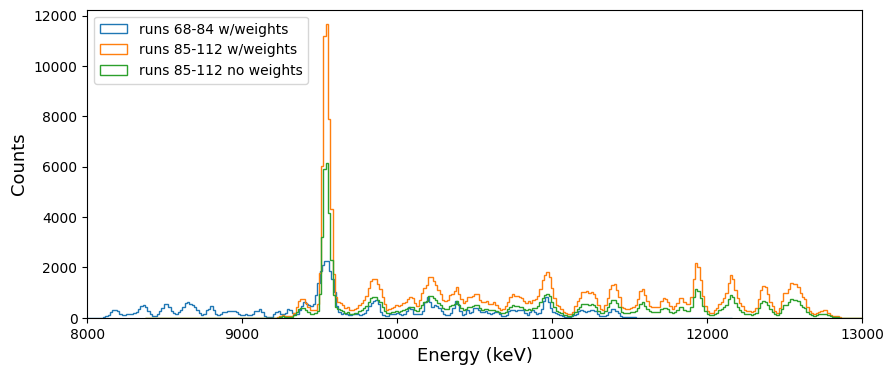

In [39]:
run85_112scaled, run85_112og, run85_112window= newcounts(xavgcal85_112, [8371,13360], 333, sfactor = 0.8*0.6*0.8*1.6)

plt.figure(figsize = (10,4))
# plt.stairs(run85_112og, run85_112window, color = 'orange' , label = 'Original')
# plt.stairs(run85_112scaled, run85_112window, color = 'black', label = 'runs 85-112 w/stairs')
plt.hist(xavgcal68_84, bins = 327, range = [7247,12158], histtype= 'step',label = 'runs 68-84 w/weights', weights = np.full(len(xavgcal68_84),1.01))
plt.hist(xavgcal85_112, bins = 333, range = [8371,13360], histtype= 'step', label = 'runs 85-112 w/weights', weights = np.full(len(xavgcal85_112),1.89))
plt.hist(xavgcal85_112, bins = 333, range = [8371,13360], histtype= 'step', label = 'runs 85-112 no weights')
# plt.stairs(run68_84scaled, run68_84window, color = 'red', label = 'runs 68-84 w/stairs')
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.legend(loc = 'upper left')
plt.xlim(8000,13000)

### Normalizing runs 113-134

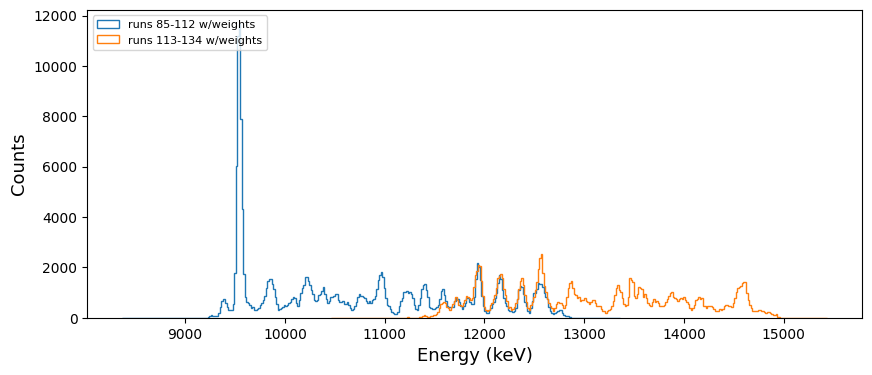

In [41]:
run113_134scaled, run113_134og, run113_134window= newcounts(xavgcal113_134, [10462,15434], 331, sfactor = 1.7*0.8*0.6*0.8*1.7)

plt.figure(figsize = (10,4))
plt.hist(xavgcal85_112, bins = 333, range = [8371,13360], histtype= 'step', label = 'runs 85-112 w/weights', weights = np.full(len(xavgcal85_112),1.89))
plt.hist(xavgcal113_134, bins = 331, range = [10462,15434], histtype= 'step', label = 'runs 113-134 w/weights', weights = np.full(len(xavgcal113_134),2.76))
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.legend(loc = 'upper left', fontsize = 8)
# plt.xlim(11000,15000)

### All together

(0.0, 3000.0)

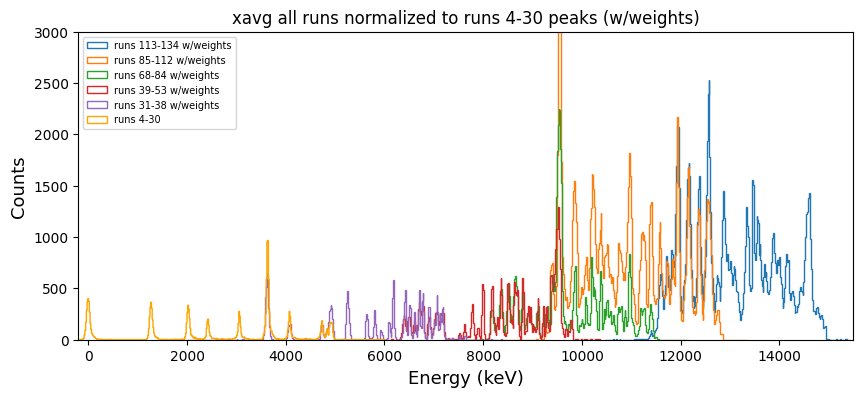

In [47]:

plt.figure(figsize = (10,4))
plt.hist(xavgcal113_134, bins = 331, range = [10462,15434], histtype= 'step', label = 'runs 113-134 w/weights', weights = np.full(len(xavgcal113_134),2.76))
plt.hist(xavgcal85_112, bins = 333, range = [8371,13360], histtype= 'step', label = 'runs 85-112 w/weights', weights = np.full(len(xavgcal85_112),1.89))
plt.hist(xavgcal68_84, bins = 327, range = [7247,12158], histtype= 'step',label = 'runs 68-84 w/weights', weights = np.full(len(xavgcal68_84),1.01))
plt.hist(xavgcal39_53, bins = 347, range = [5158,10366], histtype= 'step', label = 'runs 39-53 w/weights', weights = np.full(len(xavgcal39_53),1.32))
plt.hist(xavgcal31_38, bins = 441, range = [1758,8378], histtype= 'step', label = 'runs 31-38 w/weights', weights = np.full(len(xavgcal31_38),1.58))
plt.hist(xavgcal4_30, bins = 575+1, range = [-2602,6017+15], color = 'orange', histtype= 'step', label = 'runs 4-30')
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.legend(loc = 'upper left', fontsize = 7)
plt.title('xavg all runs normalized to runs 4-30 peaks (w/weights)')
plt.xlim(-200,15500)
plt.ylim(0,3000)


(0.0, 3000.0)

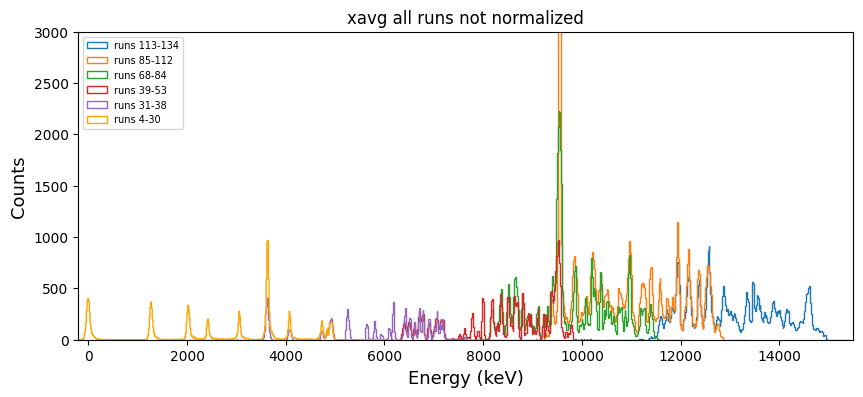

In [49]:
plt.figure(figsize = (10,4))
plt.hist(xavgcal113_134, bins = 331, range = [10462,15434], histtype= 'step', label = 'runs 113-134')
plt.hist(xavgcal85_112, bins = 333, range = [8371,13360], histtype= 'step', label = 'runs 85-112')
plt.hist(xavgcal68_84, bins = 327, range = [7247,12158], histtype= 'step',label = 'runs 68-84')
plt.hist(xavgcal39_53, bins = 347, range = [5158,10366], histtype= 'step', label = 'runs 39-53')
plt.hist(xavgcal31_38, bins = 441, range = [1758,8378], histtype= 'step', label = 'runs 31-38')
plt.hist(xavgcal4_30, bins = 575+1, range = [-2602,6017+15], color = 'orange', histtype= 'step', label = 'runs 4-30')
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
plt.legend(loc = 'upper left', fontsize = 7)
plt.title('xavg all runs not normalized')
plt.xlim(-200,15500)
plt.ylim(0,3000)

In [190]:
s = [1,1.71,1.403,0.776,0.64,0.74]
sfactors = []
sfactors.append(np.full(len(xavgcal4_30),s[0]))
sfactors.append(np.full(len(xavgcal31_38),s[1]))
sfactors.append(np.full(len(xavgcal39_53),s[2]))
sfactors.append(np.full(len(xavgcal68_84),s[3]))
sfactors.append(np.full(len(xavgcal85_112),s[4]))
sfactors.append(np.full(len(xavgcal113_134),s[5]))

totweights = np.concatenate(sfactors)


(0.0, 15000.0)

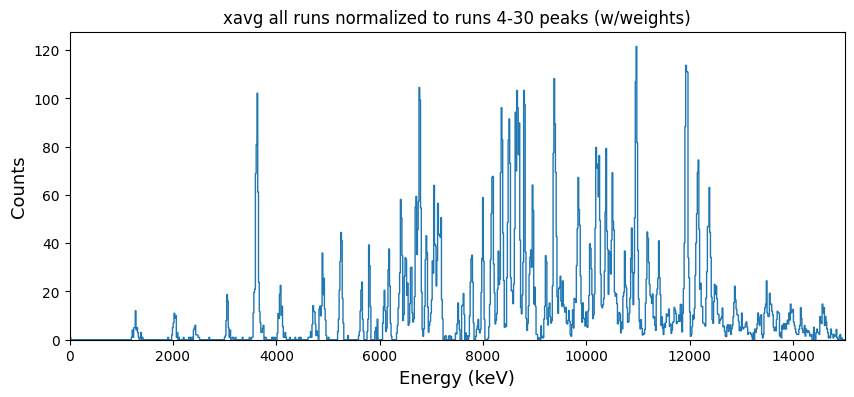

In [194]:
plt.figure(figsize = (10,4))
plt.hist(totaldeutE, bins = 1202, range = [-2602,15434], histtype= 'step', weights = totweights)
plt.ylabel('Counts', fontsize = 13)
plt.xlabel('Energy (keV)', fontsize = 13)
# plt.legend(loc = 'upper left', fontsize = 7)
plt.title('xavg all runs normalized to runs 4-30 peaks (w/weights)')
plt.xlim(0,15000)

### Residual Plots

Want to compare the volumes (area) of peaks used for normalization. For example, what the volume of the 3.623 MeV in runs 4-30 compares to runs 31-38 after normalizing runs 31-38 to runs 4-30.

hdtv fitting is better and so I am exporting the histograms to text files so I can read it into hdtv.

In [18]:
runs430his = np.histogram(xavgcal4_30, bins = 575+1, range = [-2602,6017+15])
runs3138his = np.histogram(xavgcal31_38, bins = 441, range = [1758,8378],weights = np.full(len(xavgcal31_38),1.4))
runs3953his = np.histogram(xavgcal39_53, bins = 347, range = [5158,10366], weights = np.full(len(xavgcal39_53),0.9*1.7))
runs6884his = np.histogram(xavgcal68_84, bins = 327, range = [7247,12158], weights = np.full(len(xavgcal68_84),0.9*1.7*0.7))
runs85112his = np.histogram(xavgcal85_112, bins = 333, range = [8371,13360], weights = np.full(len(xavgcal85_112),0.9*1.7*0.7*0.8))
runs113134his = np.histogram(xavgcal113_134, bins = 331, range = [10462,15434], weights = np.full(len(xavgcal113_134),0.9*1.7*0.7*0.8*1.2))
np.savetxt('runs4_30xavg.txt', runs430his[0])
np.savetxt('runs31_38xavg.txt', runs3138his[0])
np.savetxt('runs39_53xavg.txt', runs3953his[0])
np.savetxt('runs68_84xavg.txt', runs6884his[0])
np.savetxt('runs85_112xavg.txt', runs85112his[0])
np.savetxt('runs113_134xavg.txt', runs113134his[0])

Used libreoffice to calculate residuals and put results in a text file. I will import that here and plot the residuals in volume of the peaks.

(3.0, 13.0)

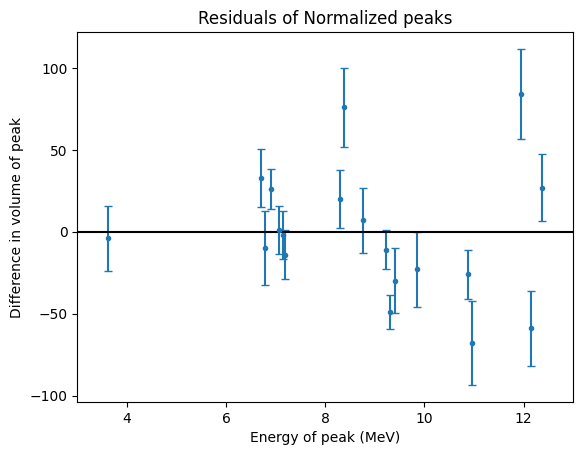

In [8]:
residuals = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/Residuals.txt')

plt.figure()
plt.errorbar(residuals[:,0], residuals[:,1], yerr = residuals[:,2], marker = '.', linestyle = '',capsize = 3)
plt.xlabel('Energy of peak (MeV)')
plt.ylabel('Difference in volume of peak')
plt.title('Residuals of Normalized peaks')
plt.hlines(0, xmin = 3, xmax = 13, color = 'black')
plt.xlim((3,13))

(3.0, 13.0)

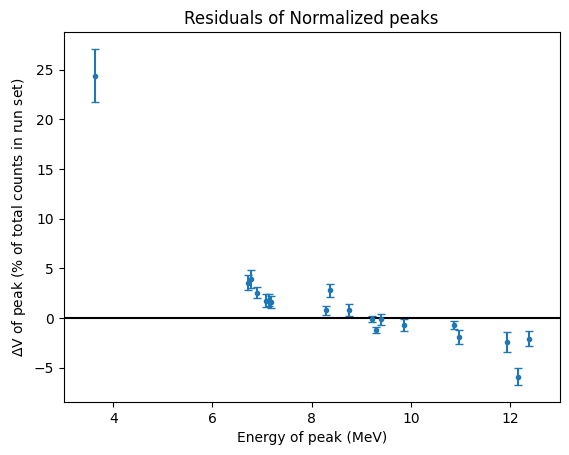

In [25]:
residuals = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/residuals_percent.txt')

plt.figure()
plt.errorbar(residuals[:,0], residuals[:,1], yerr = residuals[:,2], marker = '.', linestyle = '',capsize = 3)
plt.xlabel('Energy of peak (MeV)')
plt.ylabel('$\Delta$V of peak (% of total counts in run set)', fontsize = 10)
plt.title('Residuals of Normalized peaks')
plt.hlines(0, xmin = 3, xmax = 13, color = 'black')
plt.xlim((3,13))

Text(0, 0.5, 'Volume of peak wrt total counts of run set (%)')

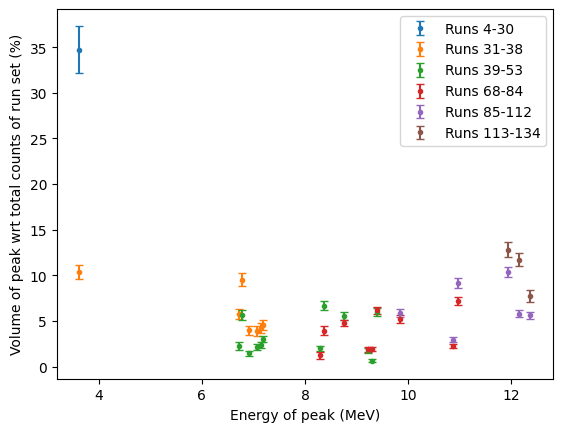

In [45]:
runs430per = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/runs4_30peakperc.txt')
runs3138per = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/runs31_38peakperc.txt')
runs3953per = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/runs39_53peakperc.txt')
runs6884per = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/runs68_84peakperc.txt')
runs85112per = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/runs85_112peakperc.txt')
runs113134per = np.loadtxt('/home/dhoulihan/Projects/SPS_CEBRA_Oct2022ad/Analysis/CeBrA_cal/xavg/Norm_his/runs113_134peakperc.txt')

plt.figure()
plt.errorbar(runs430per[0], runs430per[1], yerr = runs430per[2], marker = '.', linestyle = '',capsize = 3, label = 'Runs 4-30')
plt.errorbar(runs3138per[:,0], runs3138per[:,1], yerr = runs3138per[:,2], marker = '.', linestyle = '',capsize = 3,  label = 'Runs 31-38')
plt.errorbar(runs3953per[:,0], runs3953per[:,1], yerr = runs3953per[:,2], marker = '.', linestyle = '',capsize = 3,  label = 'Runs 39-53')
plt.errorbar(runs6884per[:,0], runs6884per[:,1], yerr = runs6884per[:,2], marker = '.', linestyle = '',capsize = 3,  label = 'Runs 68-84')
plt.errorbar(runs85112per[:,0], runs85112per[:,1], yerr = runs85112per[:,2], marker = '.', linestyle = '',capsize = 3,  label = 'Runs 85-112')
plt.errorbar(runs113134per[:,0], runs113134per[:,1], yerr = runs113134per[:,2], marker = '.', linestyle = '',capsize = 3,  label = 'Runs 113-134')
plt.legend(loc = 'best')
plt.xlabel('Energy of peak (MeV)')
plt.ylabel('Volume of peak wrt total counts of run set (%)')

### Old Code

In [ ]:
# # # from hdtv, I found the scaling factor to be 1.6 +- 0.2
# scale = 1.6; dscale = 0.2

# bins = 441; ranges = [1758,8378]

# # making bins of length 15keV 
# window = np.linspace(ranges[0],ranges[1], bins)

# # counting how many elements are in each window (bin)
# def countelements(arr, start, stop):
#     counts = 0
#     for j in arr:
#         if start <= j <= stop:
#             counts += 1
#     return counts


# ogcount = np.zeros(len(window))
# newcount = np.zeros(len(window))
# additions = []
# # number = np.zeros(len(window))
# for i in range(len(window)-1):
#     # finding the amount of counts in each bin originally
#     ogcount[i] = countelements(np.array(xavgcal31_38), window[i], window[i+1])

#     # multiplying by the scaling factor
#     newcount[i] = ogcount[i]*scale

In [ ]:
# window = np.linspace(ranges[0],ranges[1]+15, bins+1)

# plt.figure()
# plt.stairs(ogcount, window, color = 'orange' , label = 'Original')
# plt.stairs(newcount, window, color = 'black', label = 'scaled (s = 1.6)')
# # plt.hist(xavgcal4_30, bins = 575+1, range = [-2602,6017+15], color = 'orange', histtype= 'step', label = 'runs 4-30')
# plt.ylabel('Counts', fontsize = 13)
# plt.xlabel('Energy (keV)', fontsize = 13)
# plt.legend(loc = 'upper left')
# # plt.xlim(0,8300)